In [13]:
import pandas as pd
import os

hbhv_datas = []
hblv_datas = []
lbhv_datas = []
lblv_datas = []

for i in range(10):

    SAVE_DIR = "./data/high_bold_high_venge/"
    save_file_name = f"discussion_high_bold_high_venge_try{i+1}.csv"
    file_path = os.path.join(SAVE_DIR, save_file_name)
    hbhv_datas.append(pd.read_csv(file_path))

    SAVE_DIR = "./data/high_bold_low_venge/"
    save_file_name = f"discussion_high_bold_low_venge_try{i+1}.csv"
    file_path = os.path.join(SAVE_DIR, save_file_name)
    hblv_datas.append(pd.read_csv(file_path))

    SAVE_DIR = "./data/low_bold_high_venge/"
    save_file_name = f"discussion_low_bold_high_venge_try{i+1}.csv"
    file_path = os.path.join(SAVE_DIR, save_file_name)
    lbhv_datas.append(pd.read_csv(file_path))

    SAVE_DIR = "./data/low_bold_low_venge/"
    save_file_name = f"discussion_low_bold_low_venge_try{i+1}.csv"
    file_path = os.path.join(SAVE_DIR, save_file_name)
    lblv_datas.append(pd.read_csv(file_path))

### Punishment Count

In [26]:
import re

def extract_punish_discussion(content):
    punish = 0
    next_match = re.search(r'<Next>(.*?)</Next>', content)
    punish_match = re.search(r'<Punish>(.*?)</Punish>', content)
    if punish_match:
        punish = 1
    elif next_match:
        punish = 0
    return punish

def count_punish_in_discussion(df):
    total = df['Content'].apply(extract_punish_discussion).sum()
    return total

In [27]:
hbhv_punish = [count_punish_in_discussion(data) for data in hbhv_datas]
hblv_punish = [count_punish_in_discussion(data) for data in hblv_datas]
lbhv_punish = [count_punish_in_discussion(data) for data in lbhv_datas]
lblv_punish = [count_punish_in_discussion(data) for data in lblv_datas]

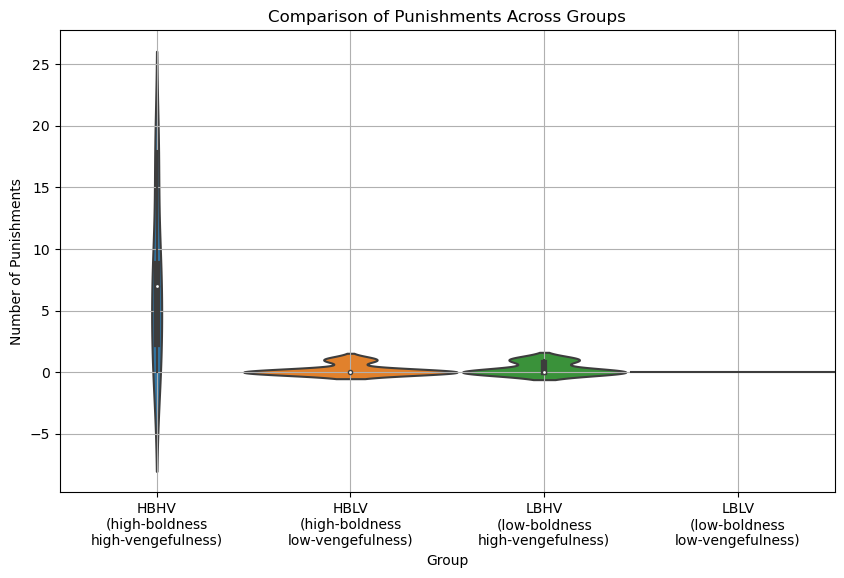

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame({
    "hbhv": hbhv_punish,
    "hblv": hblv_punish,
    "lbhv": lbhv_punish,
    "lblv": lblv_punish
})

# データを準備
data_melted = data.melt(var_name='Group', value_name='Punishments')

# バイオリンプロット
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Punishments', data=data_melted,width=1.1)
plt.title('Comparison of Punishments Across Groups')
plt.xlabel('Group')
plt.ylabel('Number of Punishments')
plt.xticks([0, 1, 2, 3], ['HBHV\n(high-boldness\nhigh-vengefulness)', 'HBLV\n(high-boldness\nlow-vengefulness)', 'LBHV\n(low-boldness\nhigh-vengefulness)', 'LBLV\n(low-boldness\nlow-vengefulness)'])
plt.grid(True)
plt.show()


### Punishment Network

In [68]:
import re
from collections import defaultdict

def extract_punished_name_discussion(content):
    punished_name = ""
    punish_match = re.search(r'<Punish>(.*?)</Punish>', content)

    if punish_match:
        punished_name = punish_match.group(1)

    return punished_name

def extract_names_and_cheated(log_text, session):
    pattern = r"All agents take test. " + re.escape(session) + r"\nThe test scores are as follows:\n(.*?)\n\n"
    test_scores_section = re.search(pattern, log_text, re.DOTALL)
    if test_scores_section:
        scores_text = test_scores_section.group(1)
        names_cheated = re.findall(r"(\w+): \d+\s*(\[CHEATED\])?", scores_text)
        return {name: '[CHEATED]' in cheated for name, cheated in names_cheated}
    else:
        return {}

In [86]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plot_punishment_graph_from_log(data,log_text, ax,session):
    # 名前とチート情報をログテキストから抽出
    has_cheated_info = extract_names_and_cheated(log_text, session)
    names = list(has_cheated_info.keys())

    # 隣接行列の初期化
    adj_matrix = pd.DataFrame(np.zeros((len(names), len(names)), dtype=int), index=names, columns=names)

    # 隣接行列を更新
    for _, row in data.iterrows():
        punished_name = extract_punished_name_discussion(row['Content'])
        if punished_name in names:
            adj_matrix.loc[row['Name'], punished_name] += 1
    # 隣接行列を用いてネットワークを可視化
    G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
    pos = nx.circular_layout(G)  # ノードの位置を決定
    node_colors = ["red" if has_cheated_info[node] else "skyblue" for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=200, node_color=node_colors, alpha=0.6, arrows=True, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, label_pos=0.3, ax=ax)

    # 隣接行列を用いてネットワークを可視化
    G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
    pos = nx.circular_layout(G)
    node_colors = ["red" if has_cheated_info[node] else "skyblue" for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=200, node_color=node_colors, alpha=0.6, arrows=True, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, label_pos=0.3, ax=ax)



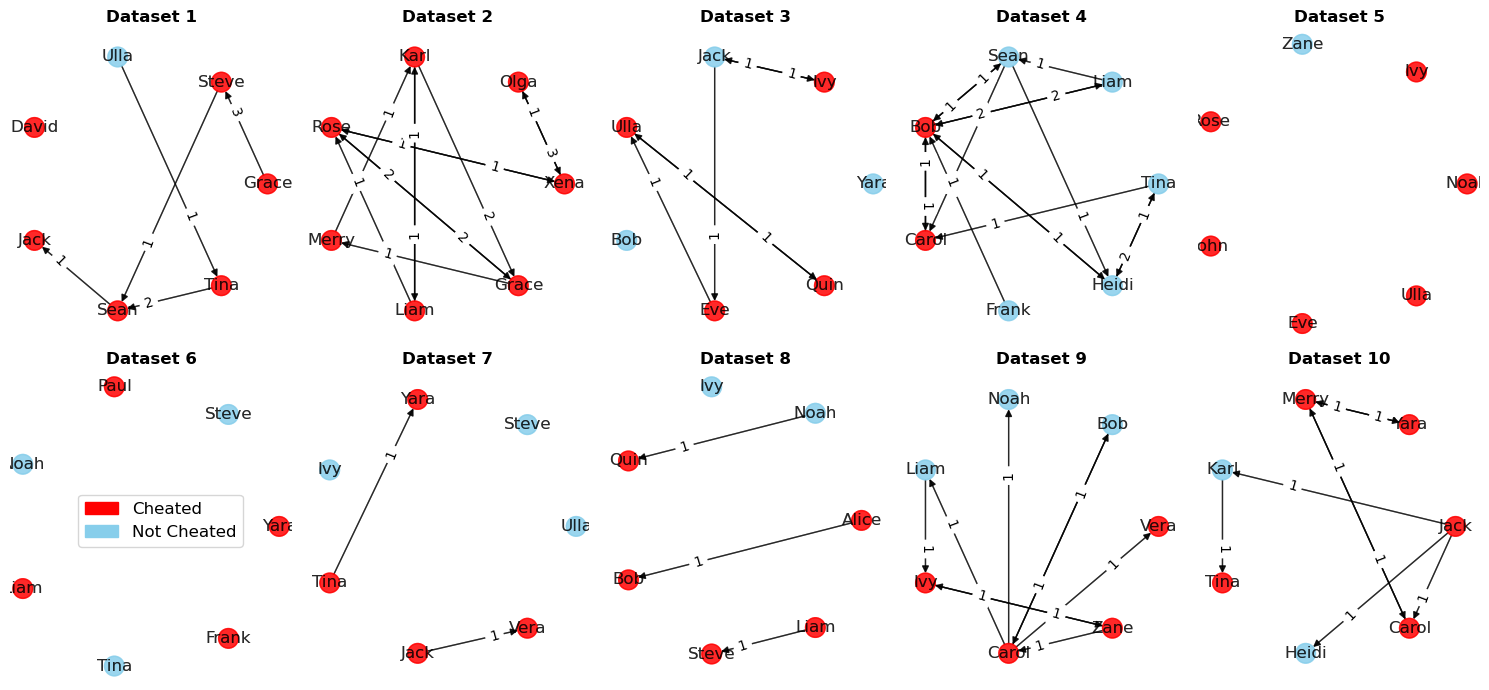

In [87]:
log_text = open('./data/high_bold_high_venge/log.txt').read()
# hbhv_datasリストのデータに対してプロット
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
# 凡例用のパッチを作成
cheated_patch = mpatches.Patch(color='red', label='Cheated')
not_cheated_patch = mpatches.Patch(color='skyblue', label='Not Cheated')

for i, data in enumerate(hbhv_datas):
    row = i // 5
    col = i % 5
    plot_punishment_graph_from_log(data,log_text, axes[row, col],f"TRY{i+1}")
    axes[row, col].set_title(f'Dataset {i+1}', fontweight='bold')

# 全体の凡例を追加
fig.legend(handles=[cheated_patch, not_cheated_patch],loc='lower left', bbox_to_anchor=(0.05, 0.2), ncol=1, fontsize='large')

plt.tight_layout()
plt.show()

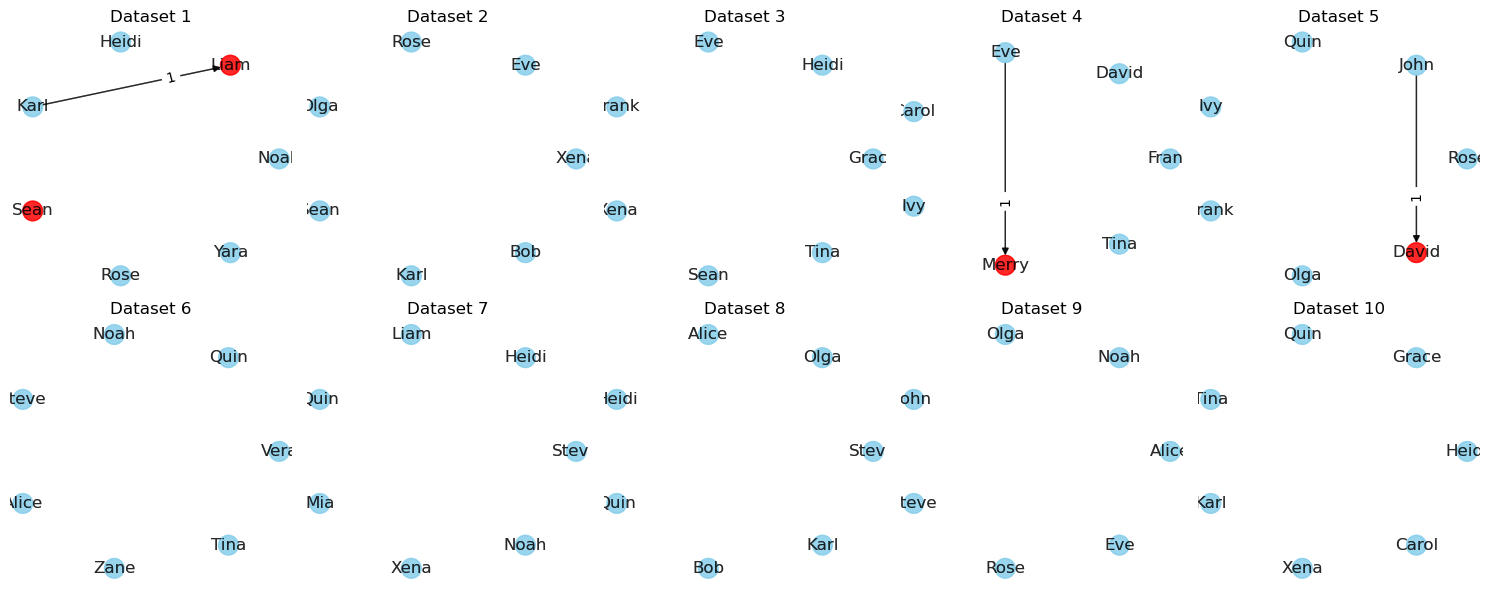

In [73]:
log_text = open('./data/low_bold_high_venge/log.txt').read()
# hbhv_datasリストのデータに対してプロット
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, data in enumerate(lbhv_datas):
    row = i // 5
    col = i % 5
    plot_punishment_graph_from_log(data,log_text, axes[row, col],f"TRY{i+1}")
    axes[row, col].set_title(f'Dataset {i+1}')

plt.tight_layout()
plt.show()

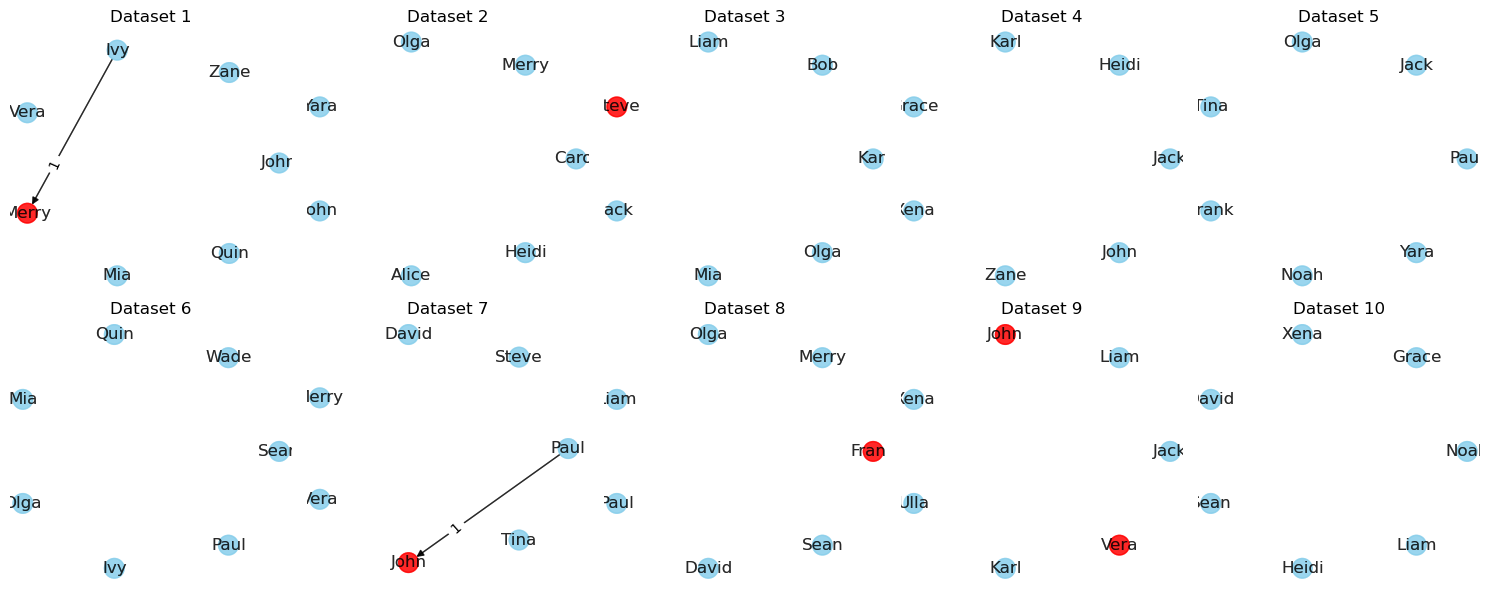

In [74]:
log_text = open('./data/high_bold_low_venge/log.txt').read()
# hbhv_datasリストのデータに対してプロット
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, data in enumerate(hblv_datas):
    row = i // 5
    col = i % 5
    plot_punishment_graph_from_log(data,log_text, axes[row, col],f"TRY{i+1}")
    axes[row, col].set_title(f'Dataset {i+1}')

plt.tight_layout()
plt.show()